### Problem statement:
To build a CNN based model that can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
!pip install Keras==2.1.6

In [ ]:
!pip install tensorflow

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [2]:
data_dir_train = pathlib.Path("Train/")
data_dir_test = pathlib.Path('Test/')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing
Load the images off disk using the helpful image_dataset_from_directory utility.

#### Create dataset
Define parameters for the loader:

In [ ]:
dir(tf.keras.preprocessing)

In [4]:
batch_size = 32
img_height = 180
img_width = 180

####  Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the Data

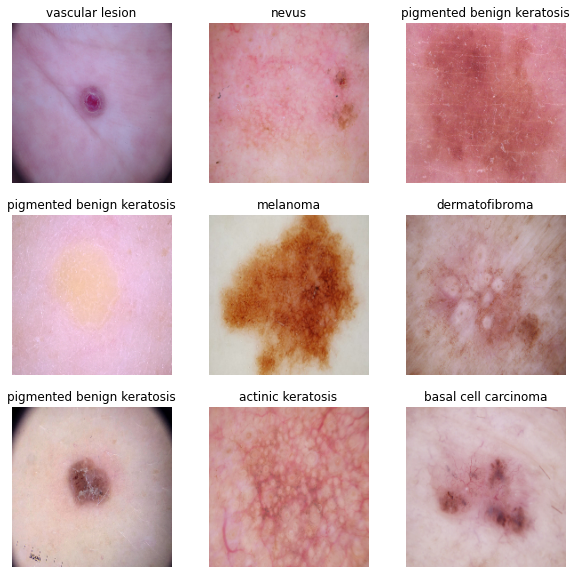

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Build CNN model that can accurately detect 9 classes present in the dataset. Using layers.experimental.preprocessing, rescale to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range, which is not ideal for a neural network. Therefore, lets standardize values to be in the [0, 1]

In [ ]:
dir(tf.keras.layers)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9715687


#### CNN architecture

Three convolutional layers with 16, 32 and 64 filters respectively,
followed by a max pooling layer,
and then Flatten the output of the pooling layer 
followed by a fully connected Dense layer with 128 neurons, and finally
an output layer with 9 neurons

In [48]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [49]:
 model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 310ms/step - loss: 2.0723 - accuracy: 0.2600 - val_loss: 1.7932 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 17s 300ms/step - loss: 1.6593 - accuracy: 0.4051 - val_loss: 1.5533 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 17s 307ms/step - loss: 1.4719 - accuracy: 0.4738 - val_loss: 1.4707 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 17s 308ms/step - loss: 1.3385 - accuracy: 0.5240 - val_loss: 1.5205 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 17s 304ms/step - loss: 1.2755 - accuracy: 0.5525 - val_loss: 1.4703 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 18s 320ms/step - loss: 1.1956 - accuracy: 0.5709 - val_loss: 1.3792 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 17s 308ms/step - loss: 1.1067 - accuracy: 0.6077 - val_loss: 1.3617 - val_accuracy: 0.5682

### Visualizing training results

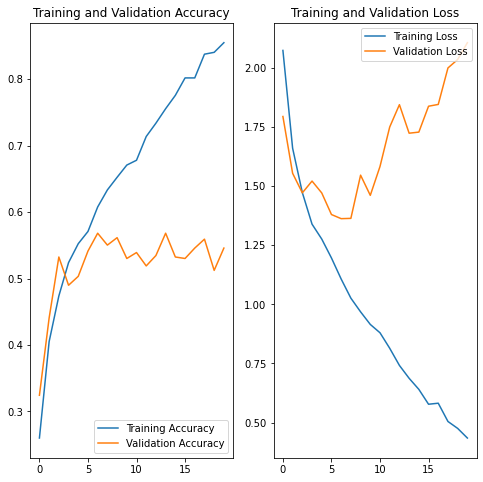

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The above plots show that validation accuracy is very low and the model has achieved only ~55% accuracy on training & validation set.

The model is overfitting on training data and scoring poorly on the validation set. 

### Data Augmentation
Data augmentation generates additional training data from existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better abd reduces overfitting.

We will implement data augmentation using Keras preprocessing layers: tf.keras.layers.experimental.preprocessing.RandomFlip, tf.keras.layers.experimental.preprocessing.RandomRotation & tf.keras.layers.experimental.preprocessing.RandomZoom

In [ ]:
! pip install tensorflow --upgrade

In [53]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

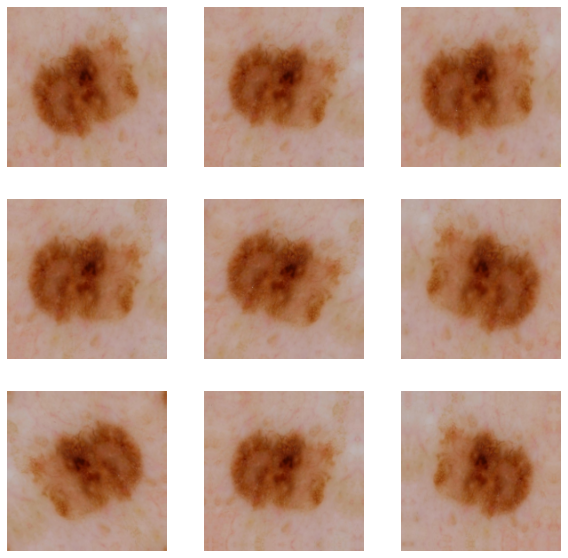

In [54]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

### Dropout

Another technique to reduce overfitting is to introduce dropout regularization

Applying dropout to a layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 
Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [56]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='softmax')
])


### Compile and train the model

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [59]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 372ms/step - loss: 2.2145 - accuracy: 0.3610 - val_loss: 2.0113 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 21s 370ms/step - loss: 1.5454 - accuracy: 0.4520 - val_loss: 1.9525 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 21s 382ms/step - loss: 1.4821 - accuracy: 0.4944 - val_loss: 1.9385 - val_accuracy: 0.3781
Epoch 4/20
56/56 [==============================] - 21s 370ms/step - loss: 1.4550 - accuracy: 0.4927 - val_loss: 1.9306 - val_accuracy: 0.3602
Epoch 5/20
56/56 [==============================] - 21s 370ms/step - loss: 1.3937 - accuracy: 0.5061 - val_loss: 1.8223 - val_accuracy: 0.4161
Epoch 6/20
56/56 [==============================] - 21s 369ms/step - loss: 1.3695 - accuracy: 0.5234 - val_loss: 1.6707 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 21s 382ms/step - loss: 1.3516 - accuracy: 0.5251 - val_loss: 1.6560 - val_accuracy: 0.4720

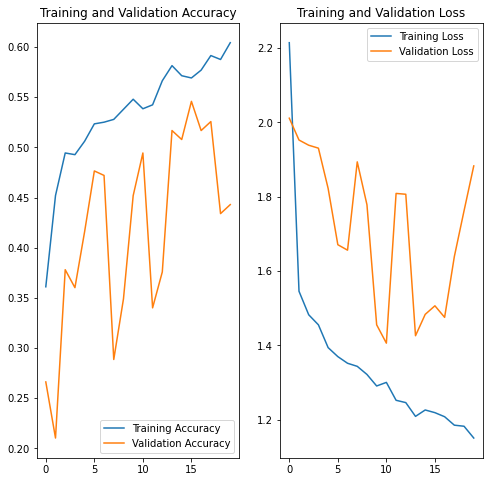

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Model accuracy has dropped to 60% from 85%





### Handling Class Imbalance

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [61]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Add 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2D6F7B1C0>:   5%|▍         | 23/500 [00:00<00:47,  9.99 Samples/s]                  

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2DCE90FA0>: 100%|██████████| 500/500 [00:03<00:00, 161.02 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2D6C0A490>: 100%|██████████| 500/500 [00:37<00:00, 13.32 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB366800A60>:   3%|▎         | 15/500 [00:00<01:04,  7.57 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB408EE96A0>: 100%|██████████| 500/500 [00:03<00:00, 130.32 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB40830C8B0>:   0%|          | 1/500 [00:00<01:10,  7.04 Samples/s]

Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB42411B580>: 100%|██████████| 500/500 [00:20<00:00, 24.34 Samples/s] 
Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7FB408EEDCD0>:   0%|          | 2/500 [00:00<00:35, 13.88 Samples/s]          

Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB4083385B0>: 100%|██████████| 500/500 [00:16<00:00, 31.20 Samples/s]                    
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2DC6AE190>:   4%|▍         | 21/500 [00:00<00:53,  9.01 Samples/s]                 

Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB2DC6AE040>: 100%|██████████| 500/500 [00:03<00:00, 136.74 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB3667EC4C0>: 100%|██████████| 500/500 [00:08<00:00, 58.41 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB2D80DA6A0>:   4%|▍         | 20/500 [00:00<00:55,  8.58 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB2D755D280>: 100%|██████████| 500/500 [00:03<00:00, 126.35 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB408338DF0>:   2%|▏         | 11/500 [00:00<00:50,  9.71 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB3667CF760>: 100%|██████████| 500/500 [00:04<00:00, 123.37 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [62]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [63]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_2033e1d3-2eb4-4d1b-b966-468a59554622.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_c4f478cb-561b-4f0d-982c-8250eb862050.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010485.jpg_dc35c87f-4157-4740-9cb0-d9e1aa4080db.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010156.jpg_9888f267-b4ae-4e13-a2cd-74be2ceb0755.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0001110.jpg_2514fde5-4e5d-49d1-b227-a5ea9dd435b2.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010468.jpg_0ee70ce7-06c2-4cd0-921f-a4dc04f127a9.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010587.jpg_35b478e4-d65f-4d68-bb7e-8adcfeff399f.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010140.jpg_d140e3a7-ac8b-4ea6-81f3-2c06c86a4792.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010543.jpg_716a463f-2bdb-49ea-b2eb-26bab5a903e2.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000417.jpg_52e8d5df-4c38-4b1c-8dc6

In [64]:
path_list[:5]

['Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_2033e1d3-2eb4-4d1b-b966-468a59554622.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_c4f478cb-561b-4f0d-982c-8250eb862050.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010485.jpg_dc35c87f-4157-4740-9cb0-d9e1aa4080db.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010156.jpg_9888f267-b4ae-4e13-a2cd-74be2ceb0755.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0001110.jpg_2514fde5-4e5d-49d1-b227-a5ea9dd435b2.jpg']

In [65]:
len(path_list)

4500

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [67]:
len(lesion_list_new)

4500

In [68]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [69]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()
len(df2)

4500

In [71]:
batch_size = 32
img_height = 180
img_width = 180

In [72]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', 
  image_size = (img_height, img_width), 
  batch_size = 32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [73]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='softmax')
])

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 64s 371ms/step - loss: 1.8236 - accuracy: 0.3618 - val_loss: 2.0175 - val_accuracy: 0.2058
Epoch 2/30
169/169 [==============================] - 63s 368ms/step - loss: 1.5601 - accuracy: 0.4238 - val_loss: 1.8367 - val_accuracy: 0.3087
Epoch 3/30
169/169 [==============================] - 63s 370ms/step - loss: 1.4347 - accuracy: 0.4644 - val_loss: 1.4088 - val_accuracy: 0.5414
Epoch 4/30
169/169 [==============================] - 65s 379ms/step - loss: 1.4070 - accuracy: 0.4835 - val_loss: 1.3421 - val_accuracy: 0.5548
Epoch 5/30
169/169 [==============================] - 67s 394ms/step - loss: 1.3575 - accuracy: 0.4985 - val_loss: 1.3691 - val_accuracy: 0.4966
Epoch 6/30
169/169 [==============================] - 68s 397ms/step - loss: 1.3249 - accuracy: 0.5206 - val_loss: 1.5025 - val_accuracy: 0.5056
Epoch 7/30
169/169 [==============================] - 69s 402ms/step - loss: 1.2969 - accuracy: 0.5193 - val_loss: 1.2927 - val_ac

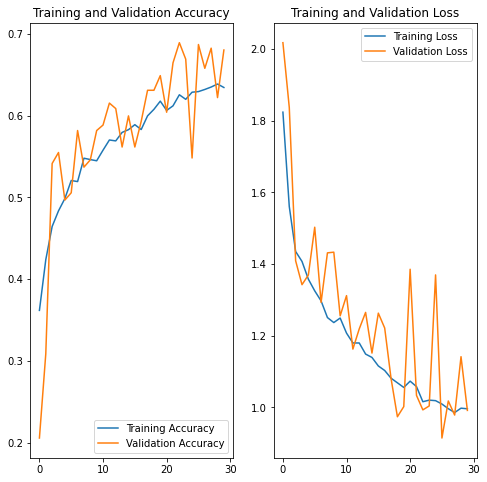

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accuracy improved to ~64% while validation accuracy jumped from 44% to 68%. 
Training and validation loss converged by after 30 epochs

## Retraining the model without batch normalization

In [13]:
data_dir_train = pathlib.Path("Train3/")
data_dir_test = pathlib.Path('Test3/')

In [14]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


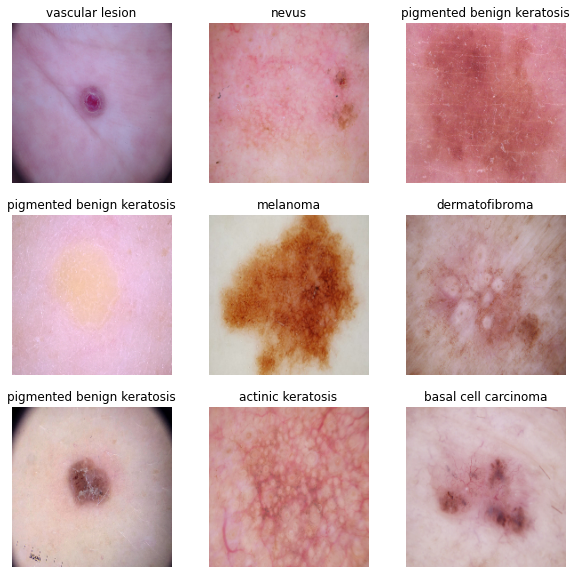

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.22063631 0.8965021


In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax')
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/Users/dhruvchopra/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 19s 326ms/step - loss: 2.0474 - accuracy: 0.2734 - val_loss: 1.6902 - val_accuracy: 0.4586
Epoch 2/20
56/56 [==============================] - 16s 294ms/step - loss: 1.6035 - accuracy: 0.4325 - val_loss: 1.5292 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 16s 289ms/step - loss: 1.4952 - accuracy: 0.4732 - val_loss: 1.4345 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 17s 298ms/step - loss: 1.3568 - accuracy: 0.5285 - val_loss: 1.3829 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 16s 292ms/step - loss: 1.2881 - accuracy: 0.5463 - val_loss: 1.3743 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 17s 302ms/step - loss: 1.2005 - accuracy: 0.5826 - val_loss: 1.4117 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 17s 298ms/step - loss: 1.1705 - accuracy: 0.5703 - val_loss: 1.3862 - val_accuracy: 0.5324
Epoch 8/20

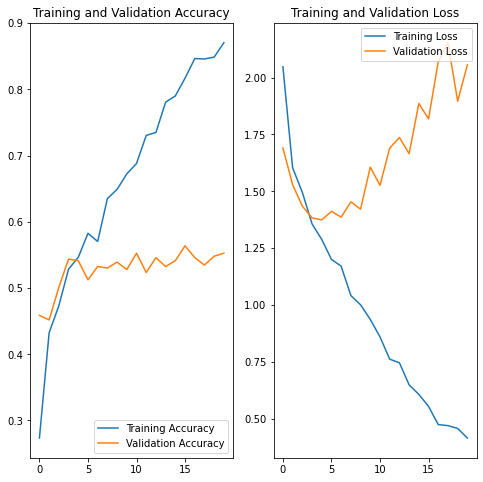

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

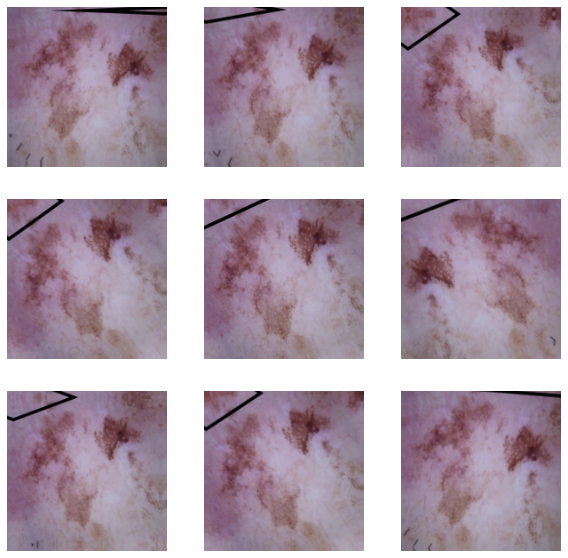

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

#### New model without batch normalization 

In [31]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='softmax')
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 355ms/step - loss: 2.1689 - accuracy: 0.2009 - val_loss: 1.9966 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 21s 366ms/step - loss: 1.9683 - accuracy: 0.2840 - val_loss: 1.8086 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 21s 372ms/step - loss: 1.6988 - accuracy: 0.3968 - val_loss: 1.6043 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 21s 371ms/step - loss: 1.4919 - accuracy: 0.4799 - val_loss: 1.5234 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 21s 373ms/step - loss: 1.4493 - accuracy: 0.4967 - val_loss: 1.4208 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 21s 374ms/step - loss: 1.4319 - accuracy: 0.4911 - val_loss: 1.4617 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 21s 368ms/step - loss: 1.3545 - accuracy: 0.5201 - val_loss: 1.4363 - val_accuracy: 0.5168

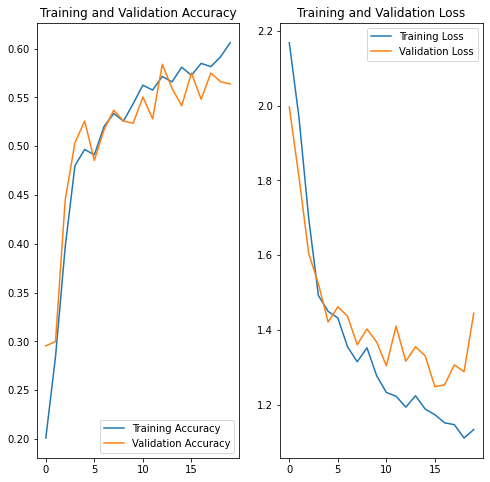

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Address Class Imbalance

In [37]:
path_to_training_dataset="Train3/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Add 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA5F5A9F040>:   1%|          | 6/500 [00:00<01:20,  6.14 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Train3/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA6979D31F0>: 100%|██████████| 500/500 [00:04<00:00, 105.87 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5F5DB4790>:   2%|▏         | 10/500 [00:00<01:16,  6.43 Samples/s]                 

Initialised with 376 image(s) found.
Output directory set to Train3/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA614D970A0>: 100%|██████████| 500/500 [00:04<00:00, 107.50 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA69EC60130>:   3%|▎         | 15/500 [00:00<01:11,  6.77 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to Train3/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5F6981640>: 100%|██████████| 500/500 [00:04<00:00, 110.07 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Train3/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FA6B22ED700>: 100%|██████████| 500/500 [00:24<00:00, 20.78 Samples/s]                    
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Train3/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FA5F68F2580>: 100%|██████████| 500/500 [00:24<00:00, 20.24 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA6973A6FA0>:   3%|▎         | 15/500 [00:00<01:08,  7.07 Samples/s]                 

Initialised with 462 image(s) found.
Output directory set to Train3/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5F6A3D8B0>: 100%|██████████| 500/500 [00:04<00:00, 108.23 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train3/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA5F6981E20>: 100%|██████████| 500/500 [00:10<00:00, 47.78 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA614D93370>:   1%|          | 5/500 [00:00<01:25,  5.81 Samples/s]                  

Initialised with 181 image(s) found.
Output directory set to Train3/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA5F5D8FF70>: 100%|██████████| 500/500 [00:04<00:00, 112.26 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA5F4CC8880>:   2%|▏         | 8/500 [00:00<01:17,  6.37 Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train3/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA5F620E160>: 100%|██████████| 500/500 [00:04<00:00, 119.32 Samples/s]


In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [39]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train3/melanoma/output/melanoma_original_ISIC_0010663.jpg_12ae1c2b-6d75-4157-9770-746572851f15.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010355.jpg_bb3e6eed-3bd4-4cd3-ae37-e1e2aed592d5.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0011112.jpg_68a3ef2e-011e-4d5f-a416-2432c7ac7abd.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0011181.jpg_a32f92d8-3937-4b9d-bfee-b9854fef6695.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010741.jpg_e9a07ce7-6455-4938-ae5a-d167674847d0.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0000139.jpg_fb270442-04f3-498c-a460-87534aaec861.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010533.jpg_79739d69-c18d-4f41-abb6-216c565666e8.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010119.jpg_d659cdcd-6ad1-497e-9fd0-251d93247a87.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0000173.jpg_01e27e81-a4d8-4cbf-a701-93d354ee30b6.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0000176.jpg_047b538b-e5bd

In [40]:
path_list[:5]

['Train3/melanoma/output/melanoma_original_ISIC_0010663.jpg_12ae1c2b-6d75-4157-9770-746572851f15.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010355.jpg_bb3e6eed-3bd4-4cd3-ae37-e1e2aed592d5.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0011112.jpg_68a3ef2e-011e-4d5f-a416-2432c7ac7abd.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0011181.jpg_a32f92d8-3937-4b9d-bfee-b9854fef6695.jpg',
 'Train3/melanoma/output/melanoma_original_ISIC_0010741.jpg_e9a07ce7-6455-4938-ae5a-d167674847d0.jpg']

In [41]:
len(path_list)

4500

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [43]:
len(lesion_list_new)

4500

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df4 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df4.head()
len(df4)

4500

In [46]:
batch_size = 32
img_height = 180
img_width = 180

In [47]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', 
  image_size = (img_height, img_width), 
  batch_size = 32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [48]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='softmax')
])

In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 78s 448ms/step - loss: 1.8632 - accuracy: 0.3030 - val_loss: 1.4819 - val_accuracy: 0.5145
Epoch 2/30
169/169 [==============================] - 76s 443ms/step - loss: 1.5093 - accuracy: 0.4323 - val_loss: 1.4191 - val_accuracy: 0.5056
Epoch 3/30
169/169 [==============================] - 71s 414ms/step - loss: 1.4122 - accuracy: 0.4685 - val_loss: 1.3298 - val_accuracy: 0.5101
Epoch 4/30
169/169 [==============================] - 69s 403ms/step - loss: 1.3550 - accuracy: 0.4961 - val_loss: 1.2586 - val_accuracy: 0.5593
Epoch 5/30
169/169 [==============================] - 70s 409ms/step - loss: 1.3099 - accuracy: 0.5089 - val_loss: 1.4283 - val_accuracy: 0.4765
Epoch 6/30
169/169 [==============================] - 69s 403ms/step - loss: 1.2847 - accuracy: 0.5150 - val_loss: 1.2643 - val_accuracy: 0.5481
Epoch 7/30
169/169 [==============================] - 69s 402ms/step - loss: 1.2235 - accuracy: 0.5397 - val_loss: 1.2330 - val_ac

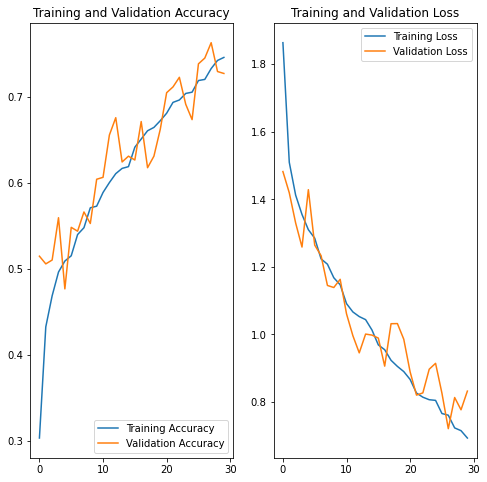

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Summary

![model_metrics](metrics.png)

Addressing class imbalance and removing batch normalization 
improved accuracy and reduced the divergency between training and validation 
thus reducing overfitting seen earlier